<img src="https://raw.githubusercontent.com/AmsterdamUMC/AmsterdamUMCdb/master/img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb Scientific Paper

Manuscript submitted for publication. Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown, Image

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Categorize numericitems table
- **Labs**: islabresult = B'1' (BIT)
- **Fluid output**: Fluitdout > 0 (at least once for all items)
- **Device data**: any item with at least once a NULL 'registeredby' value (i.e. automatically filed)

In [4]:
sql_numericitems_completeness = """
SELECT itemid, item,
    CASE 
        WHEN COUNT(
            CASE 
                WHEN islabresult = B'1' THEN 1
                ELSE NULL
            END
            ) > 0 THEN TRUE
        ELSE FALSE
    END AS islabresult,
    CASE 
        WHEN COUNT(fluidout) > 0 THEN TRUE
        ELSE FALSE
    END AS isfluidoutput,
    CASE
        WHEN COUNT(
            CASE 
                WHEN registeredby IS NULL THEN TRUE
                ELSE NULL
            END
            ) > 0 THEN TRUE
        ELSE FALSE
    END AS isdevice_data,
    COUNT(DISTINCT admissionid) AS n_admissions_documented
FROM numericitems
GROUP BY itemid, item
ORDER BY COUNT(DISTINCT admissionid) DESC
"""
numericitems_completeness = pd.read_sql(sql_numericitems_completeness,con)
numericitems_completeness.head(5)

,itemid,item,islabresult,isfluidoutput,isdevice_data,n_admissions_documented
0,6640,Hartfrequentie,False,False,True,23105
1,6709,Saturatie (Monitor),False,False,True,23058
2,9947,Glucose (bloed),True,False,False,22262
3,9941,Kreatinine (bloed),True,False,False,22259
4,9960,Hb (bloed),True,False,False,22258


# Calculate compleness percentage for numericitems

In [5]:
num_admissions = pd.read_sql("SELECT COUNT(DISTINCT admissionid) FROM admissions", con).values[0][0]

numericitems_completeness['completed_pt'] = 100*numericitems_completeness['n_admissions_documented']/num_admissions
numericitems_completeness.head()

,itemid,item,islabresult,isfluidoutput,isdevice_data,n_admissions_documented,completed_pt
0,6640,Hartfrequentie,False,False,True,23105,99.995672
1,6709,Saturatie (Monitor),False,False,True,23058,99.792262
2,9947,Glucose (bloed),True,False,False,22262,96.347269
3,9941,Kreatinine (bloed),True,False,False,22259,96.334285
4,9960,Hb (bloed),True,False,False,22258,96.329958


# Get completeness for device data
Definition: documented at least once during an admission

In [6]:
numericitems_completeness = numericitems_completeness.sort_values(['completed_pt'], ascending=False)
numericitems_completeness[(numericitems_completeness['islabresult'] == False) &
                          (numericitems_completeness['isdevice_data'] == True)
                         ].head(50)

,itemid,item,islabresult,isfluidoutput,isdevice_data,n_admissions_documented,completed_pt
0,6640,Hartfrequentie,False,False,True,23105,99.995672
1,6709,Saturatie (Monitor),False,False,True,23058,99.792262
7,8874,Ademfrequentie Monitor,False,False,True,22212,96.130875
17,6641,ABP systolisch,False,False,True,21635,93.633688
18,6642,ABP gemiddeld,False,False,True,21634,93.629360
19,6643,ABP diastolisch,False,False,True,21634,93.629360
21,6665,ST segment analyse afleiding II,False,False,True,21160,91.577945
22,6666,ST segment analyse afleiding,False,False,True,20892,90.418073
25,6664,ST segment analyse afleiding I,False,False,True,20390,88.245477
44,12279,O2 concentratie,False,False,True,15775,68.272310


# Get completeness for manually entered data
Definition: documented at least once during an admission

In [7]:
numericitems_completeness[(numericitems_completeness['islabresult'] == False) &
                          (numericitems_completeness['isdevice_data'] == False)
                         ].head(50)

,itemid,item,islabresult,isfluidoutput,isdevice_data,n_admissions_documented,completed_pt
11,8794,UrineCAD,False,True,False,21821,94.438674
23,8845,O2 l/min,False,False,False,20665,89.435644
94,8671,Thoraxdrain1 Stand,False,False,False,9945,43.040769
95,8699,Thoraxdrain1 Productie,False,True,False,9904,42.863326
99,13060,Temp Axillair,False,False,False,9475,41.006665
102,8774,Maaghevel,False,True,False,9411,40.729681
106,8789,Ontlasting,False,True,False,8591,37.180819
107,13081,A_Apache_Score,False,False,False,8324,36.025275
108,13076,A_FiO2,False,False,False,8305,35.943045
123,8779,MaagRetNietWeg,False,False,False,6216,26.902103


## Categorize listitems table
- **Labs**: islabresult = B'1' (BIT)
- **Device data**: any item with at least once a NULL 'registeredby' value (i.e. automatically filed)
- **Fully manually entered**: NOT Labs, NOT Device Data

In [8]:
sql_listitems_completeness = """
SELECT itemid, item,
    CASE 
        WHEN COUNT(
            CASE 
                WHEN islabresult = B'1' THEN 1
                ELSE NULL
            END
            ) > 0 THEN TRUE
        ELSE FALSE
    END AS islabresult,
    CASE
        WHEN COUNT(
            CASE 
                WHEN registeredby IS NULL THEN TRUE
                ELSE NULL
            END
            ) > 0 THEN TRUE
        ELSE FALSE
    END AS isdevice_data,
    COUNT(DISTINCT admissionid) AS n_admissions_documented
FROM listitems
GROUP BY itemid, item
ORDER BY COUNT(DISTINCT admissionid) DESC
"""
listitems_completeness = pd.read_sql(sql_listitems_completeness,con)
listitems_completeness.head(5)

,itemid,item,islabresult,isdevice_data,n_admissions_documented
0,10470,Reden voor ontslag,False,False,23103
1,6671,Hartritme,False,False,22913
2,10472,Ontslagbestemming,False,False,22887
3,10469,PatiëntGeslacht,False,False,22613
4,12128,Patiënt Specialisme,False,False,21805


## Calculate completeness percentage

In [9]:
listitems_completeness['completed_pt'] = 100*listitems_completeness['n_admissions_documented']/num_admissions
listitems_completeness.head()

,itemid,item,islabresult,isdevice_data,n_admissions_documented,completed_pt
0,10470,Reden voor ontslag,False,False,23103,99.987016
1,6671,Hartritme,False,False,22913,99.164719
2,10472,Ontslagbestemming,False,False,22887,99.052194
3,10469,PatiëntGeslacht,False,False,22613,97.866355
4,12128,Patiënt Specialisme,False,False,21805,94.369428


## Get completeness for manually entered listitems data
Definition: documented at least once during an admission

In [10]:
#Manually entered clinical observations 
listitems_completeness[(listitems_completeness['islabresult'] == False) &
                          (listitems_completeness['isdevice_data'] == False)
                         ].head(50)

,itemid,item,islabresult,isdevice_data,n_admissions_documented,completed_pt
0,10470,Reden voor ontslag,False,False,23103,99.987016
1,6671,Hartritme,False,False,22913,99.164719
2,10472,Ontslagbestemming,False,False,22887,99.052194
3,10469,PatiëntGeslacht,False,False,22613,97.866355
4,12128,Patiënt Specialisme,False,False,21805,94.369428
5,8189,Toedieningsweg,False,False,20646,89.353415
6,12810,Bedsoort,False,False,19361,83.792089
7,12130,PatiëntWijzeVanOpname,False,False,18632,80.637064
8,10697,Gewicht bron,False,False,18150,78.551026
9,10702,Lengte bron,False,False,17864,77.313252


# Get completeness for listitems device data
Example: ventilator mode, CRRT mode
Definition: documented at least once during an admission

In [11]:
#Device data listitems
listitems_completeness[(listitems_completeness['islabresult'] == False) &
                          (listitems_completeness['isdevice_data'] == True)
                         ].head(50)

,itemid,item,islabresult,isdevice_data,n_admissions_documented,completed_pt
12,12290,Ventilatie Mode (Set),False,True,15639,67.683719
139,12560,NIV Program Status (Set),False,True,1383,5.985458
224,14846,MFT_Behandeling,False,True,631,2.730892
227,9534,Type beademing Evita 1,False,True,614,2.657318
239,6658,IABP Frequentie,False,True,474,2.051415
240,8647,IABP Trigger,False,True,471,2.038432
261,6685,Type Beademing Evita 4,False,True,368,1.592660


# Get completeness for listitems and numericitems device data
Definition: documented at least once during an admission

In [12]:
device_data = pd.concat([
    numericitems_completeness[(numericitems_completeness['islabresult'] == False) &
                              (numericitems_completeness['isdevice_data'] == True)],
    listitems_completeness[(listitems_completeness['islabresult'] == False) &
                          (listitems_completeness['isdevice_data'] == True)]
], sort=True)
device_data.sort_values('completed_pt', ascending=False).head(150)

,completed_pt,isdevice_data,isfluidoutput,islabresult,item,itemid,n_admissions_documented
0,99.995672,True,False,False,Hartfrequentie,6640,23105
1,99.792262,True,False,False,Saturatie (Monitor),6709,23058
7,96.130875,True,False,False,Ademfrequentie Monitor,8874,22212
17,93.633688,True,False,False,ABP systolisch,6641,21635
18,93.629360,True,False,False,ABP gemiddeld,6642,21634
19,93.629360,True,False,False,ABP diastolisch,6643,21634
21,91.577945,True,False,False,ST segment analyse afleiding II,6665,21160
22,90.418073,True,False,False,ST segment analyse afleiding,6666,20892
25,88.245477,True,False,False,ST segment analyse afleiding I,6664,20390
44,68.272310,True,False,False,O2 concentratie,12279,15775


## Create device data completeness plot
Using manually labeled items

In [13]:
device_data_selection = pd.DataFrame([
    [6640, 'Heart rate'],
    [6709, 'SpO2'],
    [8874, 'Respiratory rate (monitor)'],
    [6641, 'Arterial blood pressure'],
    [6665, 'ST segment analysis'],
    [12279, 'Fraction of inspired oxygen (FiO2)'],
    [12290, 'Ventilation mode'],
    [12284, 'PEEP, tidal volume, etc.'],
    [6655, 'Central venous pressure'],
    [6678, 'Non-invasive blood pressure'],
    [6645, 'Pulmonary artery pressure'],
    [8658, 'Temperature (blood)'],
    [6656, 'Cardiac output (CO)'],
    [13062, 'Temperature (tympanic)'],
    [12558, 'Non-invasive ventilation'],
    [13058, 'Temperature (rectal)'],
    [16110, 'Temperature (oesophageal)'],
    [8835, 'Intracranial pressure'],
    [14846, 'Renal replacement therapy mode'],
    [6658, 'Intra-aortic balloon pump mode']
], columns=['itemid', 'label'])

device_data_selection_new_labels = pd.merge( device_data[device_data.itemid.isin(device_data_selection['itemid'])], 
                                                           device_data_selection ).sort_values('completed_pt', 
                                                                                                ascending=False)
device_data_selection_new_labels

,completed_pt,isdevice_data,isfluidoutput,islabresult,item,itemid,n_admissions_documented,label
0,99.995672,True,False,False,Hartfrequentie,6640,23105,Heart rate
1,99.792262,True,False,False,Saturatie (Monitor),6709,23058,SpO2
2,96.130875,True,False,False,Ademfrequentie Monitor,8874,22212,Respiratory rate (monitor)
3,93.633688,True,False,False,ABP systolisch,6641,21635,Arterial blood pressure
4,91.577945,True,False,False,ST segment analyse afleiding II,6665,21160,ST segment analysis
5,68.272310,True,False,False,O2 concentratie,12279,15775,Fraction of inspired oxygen (FiO2)
17,67.683719,True,NaN,False,Ventilatie Mode (Set),12290,15639,Ventilation mode
6,67.670735,True,False,False,PEEP (Set),12284,15636,"PEEP, tidal volume, etc."
7,63.143772,True,False,False,CVD,6655,14590,Central venous pressure
8,48.498226,True,False,False,Niet invasieve bloeddruk systolisch,6678,11206,Non-invasive blood pressure


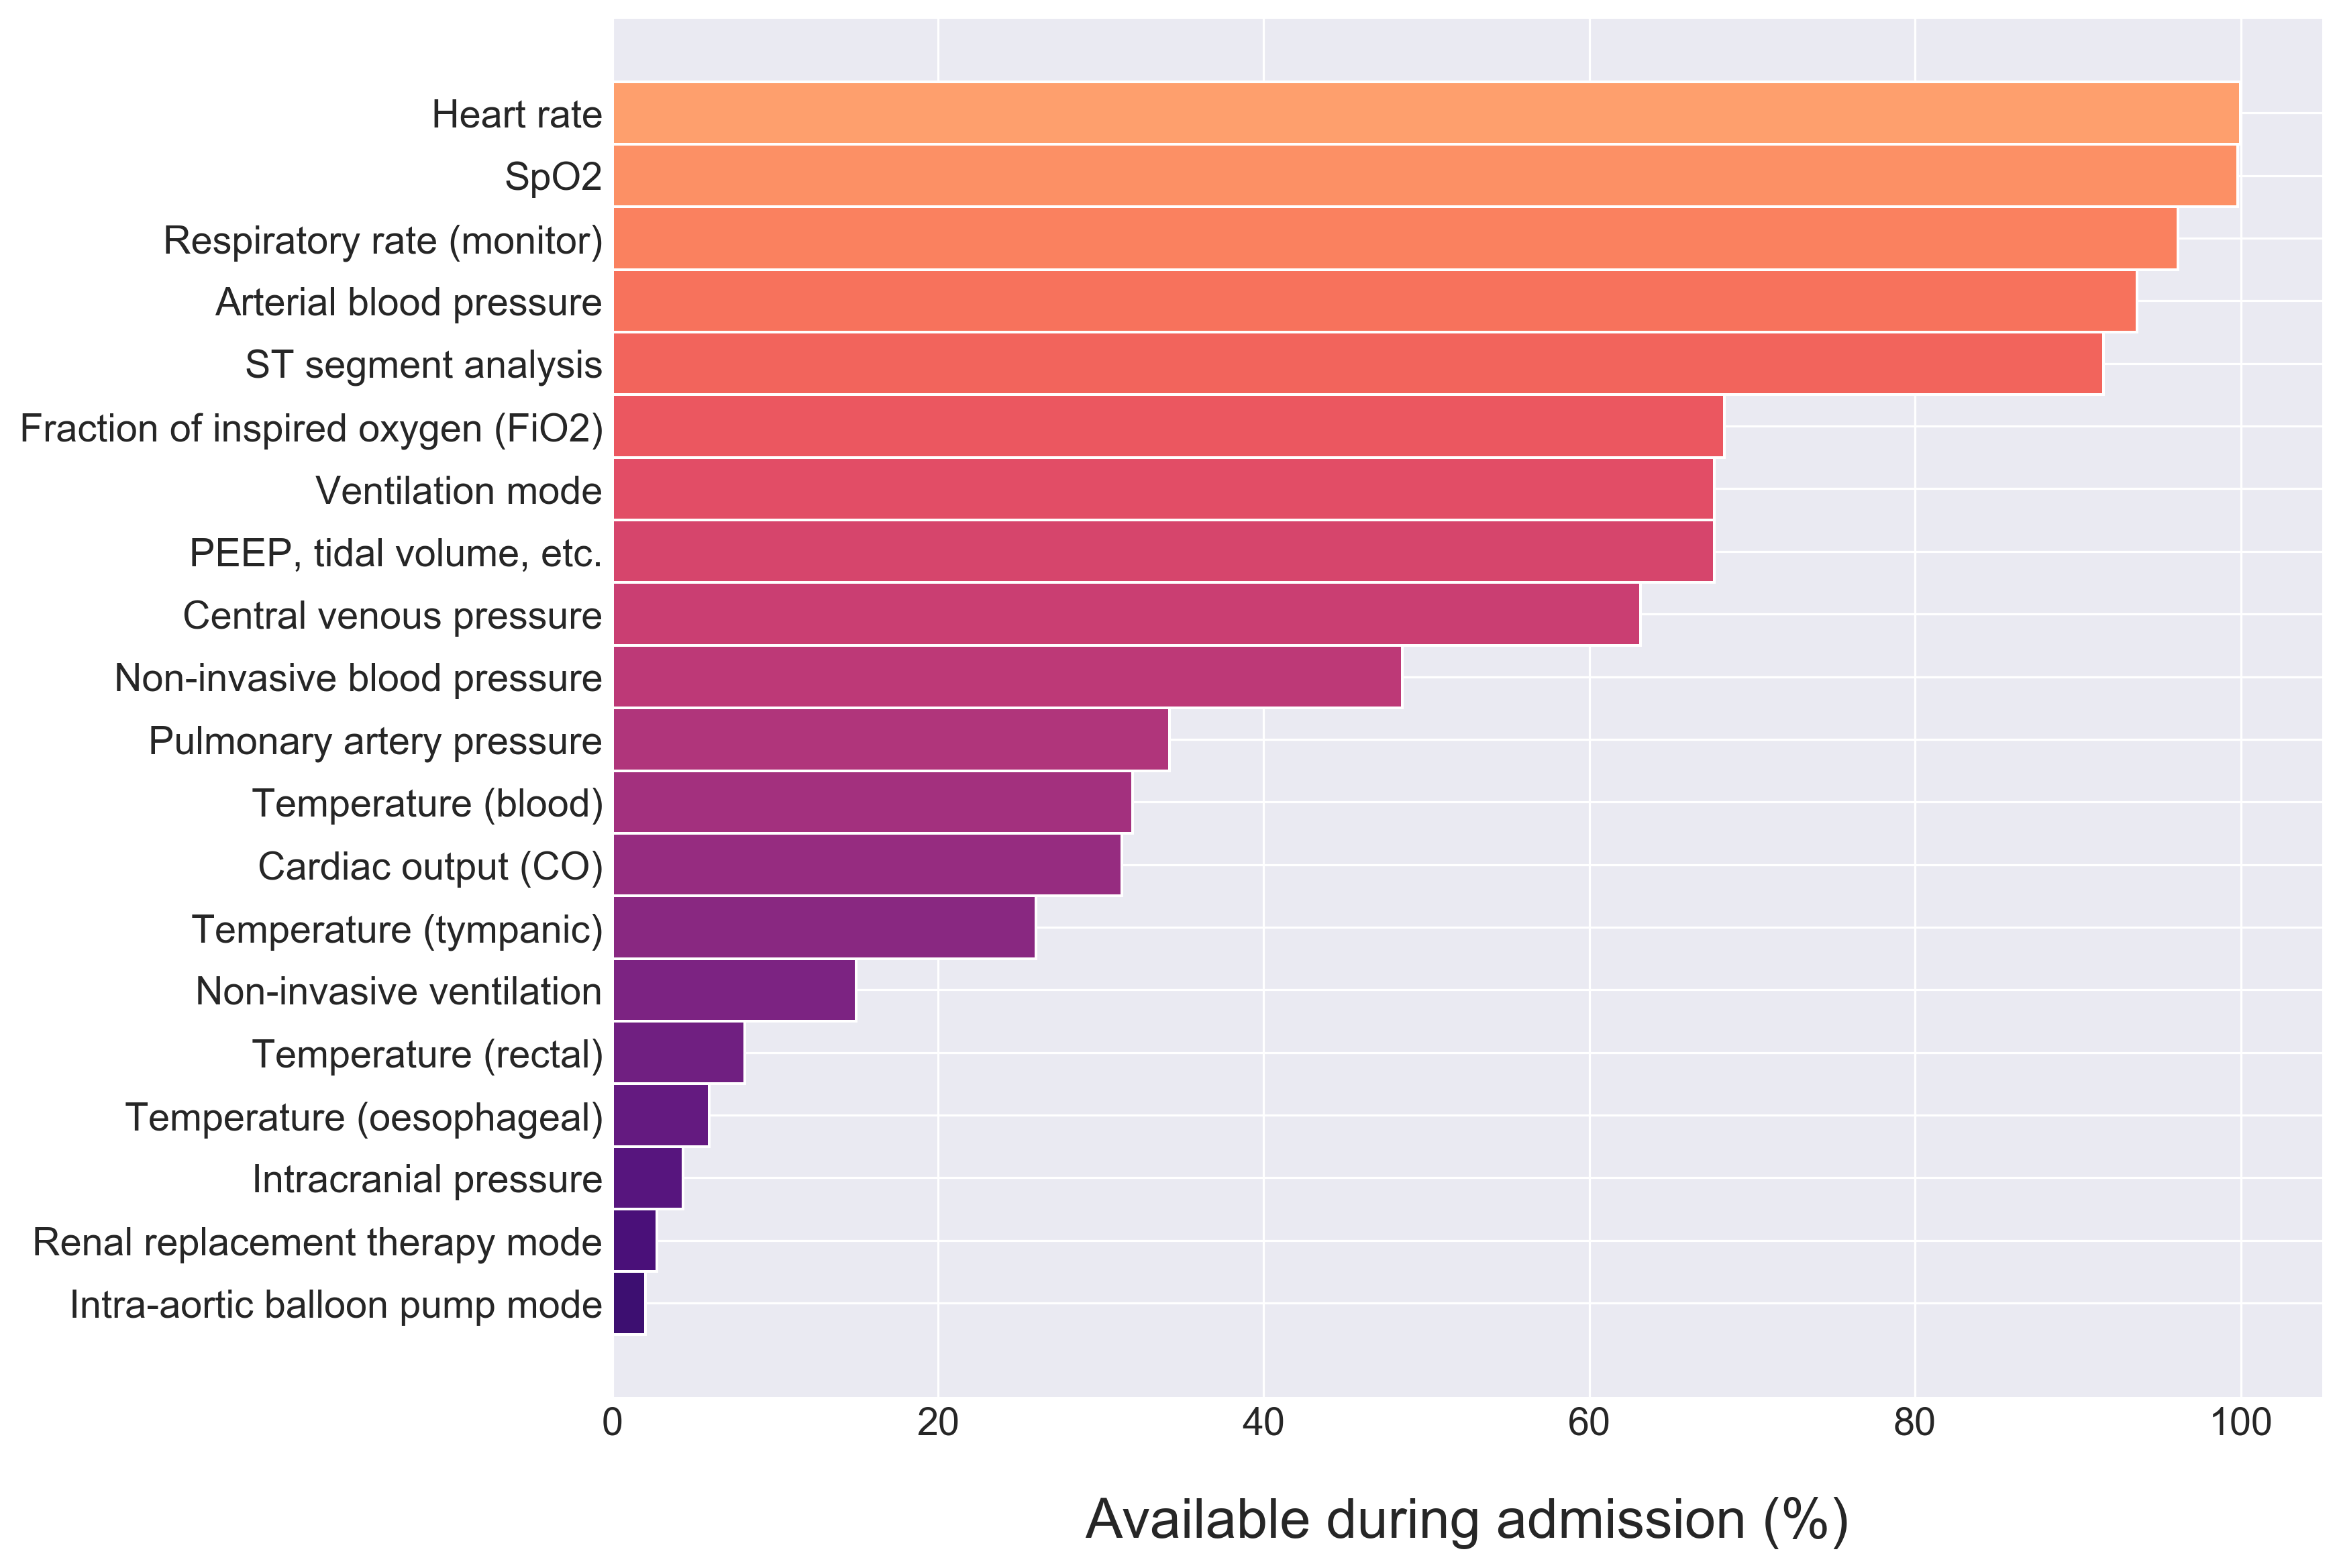

In [14]:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(device_data_selection_new_labels.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

fig, ax = plt.subplots(1, 1, figsize=(12,8), constrained_layout=True)
pos = 0
color_index = 0
for index, row in device_data_selection_new_labels.iterrows():
    ax.barh(row['label'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax.invert_yaxis()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Available during admission (%)', fontsize='xx-large', labelpad=20)
ax.tick_params(axis='both', labelsize='large')

formats = ['png']
for format in formats:
    filename = 'fig2-devicedata.{}'.format(format)
    fig.savefig(filename, format=format, dpi=fig.dpi, bbox_inches='tight')
    
plt.close() #prevents the display of the plot using display rendering
Image(filename=filename)

## Create manual items completeness plot
Using manually labeled items

In [15]:
manual_items = pd.concat([
    numericitems_completeness[(numericitems_completeness['islabresult'] == False) &
                              (numericitems_completeness['isdevice_data'] == False)],
    listitems_completeness[(listitems_completeness['islabresult'] == False) &
                          (listitems_completeness['isdevice_data'] == False)]
], sort=True)
manual_items.sort_values('completed_pt', ascending=False).head(100)

,completed_pt,isdevice_data,isfluidoutput,islabresult,item,itemid,n_admissions_documented
0,99.987016,False,NaN,False,Reden voor ontslag,10470,23103
1,99.164719,False,NaN,False,Hartritme,6671,22913
2,99.052194,False,NaN,False,Ontslagbestemming,10472,22887
3,97.866355,False,NaN,False,PatiëntGeslacht,10469,22613
11,94.438674,False,True,False,UrineCAD,8794,21821
4,94.369428,False,NaN,False,Patiënt Specialisme,12128,21805
23,89.435644,False,False,False,O2 l/min,8845,20665
5,89.353415,False,NaN,False,Toedieningsweg,8189,20646
6,83.792089,False,NaN,False,Bedsoort,12810,19361
7,80.637064,False,NaN,False,PatiëntWijzeVanOpname,12130,18632


In [16]:
manual_items_selection = pd.DataFrame([
    [6671, 'Heart rhythm'],
    [8794, 'Urine output'],
    [8189, 'Oxygen delivery device'],
    [8189, 'Oxygen flow rate'],
    [13110, 'Admission diagnosis'],
    [6732, 'Glasgow Coma Scale score'],
    [8832, 'Pupillary size and reflexes'],
    [15808, 'Sepsis at admission'],
    [9232, 'Ramsay Sedation Scale score'],
    [8699, 'Chest drain output'],
    [13060, 'Axillary temperature'],
    [8774, 'Gastric contents'],
    [15172, 'Visual Analogue Scale score'],
    [18588, 'APACHE II admission diagnosis'],
    [16997, 'APACHE IV admission diagnosis'],
    [8889, 'Tracheal suctioning'],
    [8789, 'Defaecation'],
    [8825, 'Cardiac ectopy'],
    [10673, 'Resuscitate/intubate (DNAR) code'],
    [18839, 'Nursing Activity Score']
], columns=['itemid', 'label'])

manual_items_selection_new_labels = pd.merge( manual_items[manual_items.itemid.isin(manual_items_selection['itemid'])], 
                                                           manual_items_selection ).sort_values('completed_pt', 
                                                                                                ascending=False)
manual_items_selection_new_labels

,completed_pt,isdevice_data,isfluidoutput,islabresult,item,itemid,n_admissions_documented,label
5,99.164719,False,NaN,False,Hartritme,6671,22913,Heart rhythm
0,94.438674,False,True,False,UrineCAD,8794,21821,Urine output
6,89.353415,False,NaN,False,Toedieningsweg,8189,20646,Oxygen delivery device
7,89.353415,False,NaN,False,Toedieningsweg,8189,20646,Oxygen flow rate
8,68.190080,False,NaN,False,D_Hoofdgroep,13110,15756,Admission diagnosis
9,61.533801,False,NaN,False,Pupil Links Grootte,8832,14218,Pupillary size and reflexes
10,61.468883,False,NaN,False,Actief openen van de ogen,6732,14203,Glasgow Coma Scale score
11,51.410889,False,NaN,False,Opname Sepsis,15808,11879,Sepsis at admission
12,48.355406,False,NaN,False,Ramsay score,9232,11173,Ramsay Sedation Scale score
1,42.863326,False,True,False,Thoraxdrain1 Productie,8699,9904,Chest drain output


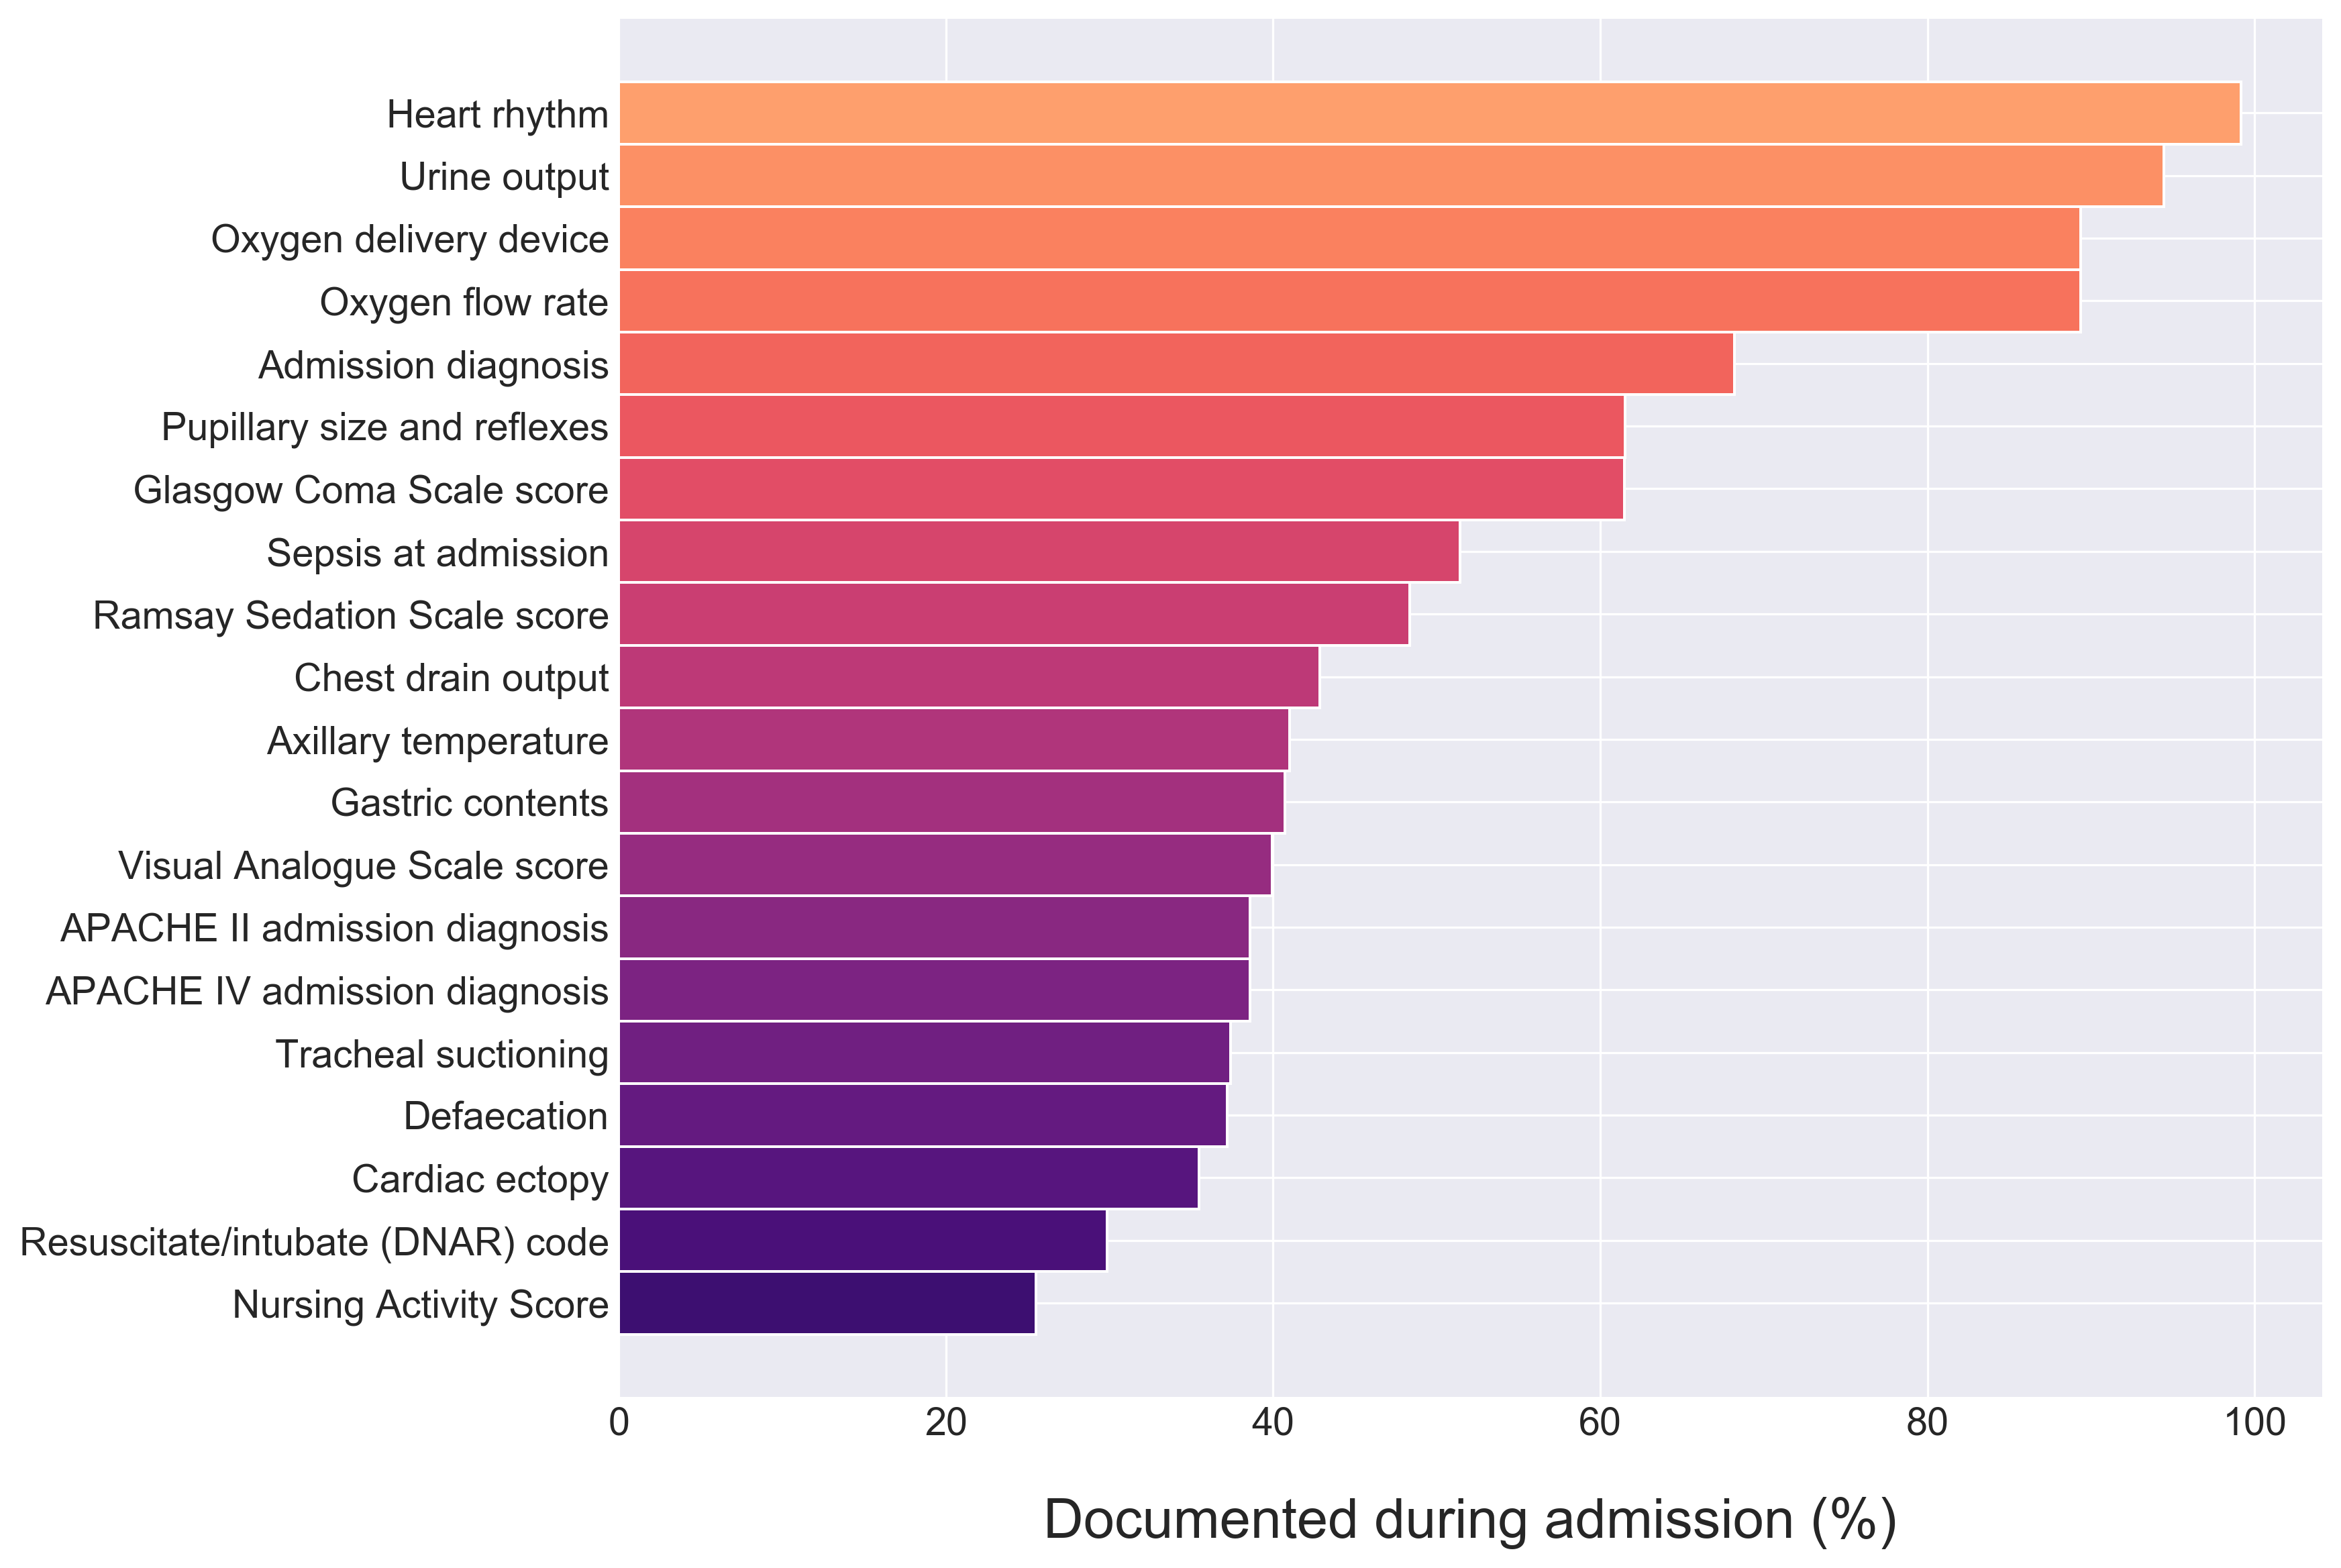

In [17]:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(manual_items_selection_new_labels.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

fig, ax = plt.subplots(1, 1, figsize=(12,8), constrained_layout=True)
pos = 0
color_index = 0
for index, row in manual_items_selection_new_labels.iterrows():
    ax.barh(row['label'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax.invert_yaxis()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Documented during admission (%)', fontsize='xx-large', labelpad=20)
ax.tick_params(axis='both', labelsize='large')

formats = ['png']
for format in formats:
    filename = 'fig2-observations.{}'.format(format)
    fig.savefig(filename, format=format, dpi=fig.dpi, bbox_inches='tight')
    
plt.close() #prevents the display of the plot using display rendering
Image(filename=filename)

## Get labresults completeness
Since laboratory data in numericitems contains both interfaced (automatically filed) data and manually entered data (about 4% of admissions by nurses and physicians), we need to combine these records into groups before calculation of the completeness score

In [18]:
#get labs mapped together
sql_labs_mapped_completeness = """
SELECT 
    CASE
        WHEN itemid IN (
            9947, --Glucose (bloed)
            6833, --Glucose Bloed 
            9557 --Glucose Astrup
        ) THEN 'Glucose'
        WHEN itemid IN (
            9941, --Kreatinine (bloed) µmol/l
            6836, --Kreatinine µmol/l (erroneously documented as µmol)
            14216 --KREAT enzym. (bloed) µmol/l
        ) THEN 'Creatinine'
        WHEN itemid IN (
            9943, --Ureum (bloed)
            6850 --Ureum
        ) THEN 'Blood Urea Nitrogen'
        WHEN itemid IN (
            9960, --Hb (bloed)
            6778, --Hemoglobine
            10286, --Hb(v.Bgs) (bloed)
            19703, --Hb poct (bloed)
            9553 --CtHB Astrup
        ) THEN 'Hemoglobin'
        WHEN itemid IN (
            11423, --Ht (bloed)
            11545, --Ht(v.Bgs) (bloed)
            6777 --Hematocriet
        ) THEN 'Hematocrit'
        WHEN itemid IN (
            9964, --Thrombo's (bloed)
            6797, --Thrombocyten
            10409, --Thrombo's citr. bloed (bloed)
            14252 --Thrombo CD61 (bloed)
        ) THEN 'Platelets'
        WHEN itemid IN (
            9965, --Leuco's (bloed) 10^9/l
            6779 --Leucocyten 10^9/l
        ) THEN 'White blood cell count'
        WHEN itemid IN (
            9924, --Natrium (bloed)
            6840, --Natrium
            9555, --Natrium Astrup
            10284 --Na (onv.ISE) (bloed)
        ) THEN 'Sodium'
        WHEN itemid IN (
            9927, --Kalium (bloed) mmol/l
            9556, --Kalium Astrup mmol/l
            6835, --Kalium mmol/l
            10285 --K (onv.ISE) (bloed) mmol/l
        ) THEN 'Potassium'
        WHEN itemid IN (
            9952, --Magnesium (bloed)
            6839 --Magnesium
        ) THEN 'Magnesium'
        WHEN itemid IN (
            10079, --CRP (bloed)
            6825 --CRP
        ) THEN 'C-reactive protein'
        WHEN itemid IN (
            9935, --Fosfaat (bloed)
            6828 --Fosfaat
        ) THEN 'Phosphate'
        WHEN itemid IN (
            11998, --CK (bloed)
            6822 --CK
        ) THEN 'Creatine kinase'
        WHEN itemid IN (
            9937, --Alb.Chem (bloed)
            6801 --Albumine chemisch
        ) THEN 'Serum albumin'
        WHEN itemid IN (
            11978, --ALAT (bloed)
            6800 --ALAT
        ) THEN 'ALAT'
        WHEN itemid IN (
            11990, --ASAT (bloed)
            6806 --ASAT
        ) THEN 'ASAT'
        WHEN itemid IN (
            10053, --Lactaat (bloed)
            6837, --Laktaat
            9580 --Laktaat Astrup
        ) THEN 'Lactate'
        WHEN itemid IN (
            12023, --LD (bloed)
            6838 --LDH
        ) THEN 'Lactate dehydrogenase'
        WHEN itemid IN (
            11984, --Alk.Fosf. (bloed)
            6803 --Alk. Fosfatase
        ) THEN 'Alkaline phosphatase'
        WHEN itemid IN (
            9945, --Bilirubine (bloed)
            6813 --Bili Totaal
        ) THEN 'Bilirubin'
        WHEN itemid IN (
            11925, --TSH (bloed)
            7071 --TSH
        ) THEN 'TSH'
         WHEN itemid IN (
             9933, --Calcium totaal (bloed)
             6817 --Calcium
        ) THEN 'Calcium (total)'
        WHEN itemid IN (
            10267, --Ca-ion (7.4) (bloed)
            6815, --Ca. geioniseerd
            9560, --Ca++ Astrup
            8915, --CA++(7.4)
            9561 --CA++(7.4) Astrup
        ) THEN 'Calcium ionized'
        
        --major components of blood gas analysis
        WHEN itemid IN (
            12310, --pH (bloed)
            6848, --PH
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213, --PCO2 (bloed) - kPa
            7433, --PO2
            9996, --PO2 (bloed)
            21214, --PO2 (bloed) - kPa
            9994, --B.E. (bloed)
            6807, --B.E.
            9992, --Act.HCO3 (bloed)
            6810, --HCO3
            9559, --Anion-Gap (bloed)
            8492, --AnGap
            12311, --O2-Saturatie (bloed)
            8903 --SO2
        ) THEN 'Blood gas analysis'
        
        --these components of blood gas will not be shown since above CASE already TRUE
        WHEN itemid IN (
            12310, --pH (bloed)
            6848 --PH
        ) THEN 'pH'
        WHEN itemid IN (
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213 --PCO2 (bloed) - kPa
        ) THEN 'PCO2'
        WHEN itemid IN (
            7433, --PO2
            9996, --PO2 (bloed)
            21214 --PO2 (bloed) - kPa
        ) THEN 'PO2'
        WHEN itemid IN (
            9994, --B.E. (bloed)
            6807 --B.E.
        ) THEN 'Base Excess'
        WHEN itemid IN (
            9992, --Act.HCO3 (bloed)
            6810 --HCO3
        ) THEN 'Actual Bicarbonate'
        WHEN itemid IN (
            9559, --Anion-Gap (bloed)
            8492 --AnGap
        ) THEN 'Anion gap'        
        WHEN itemid IN (
            12311, --O2-Saturatie (bloed)
            8903 --SO2
        ) THEN 'O2 saturation'
    ELSE item
    END AS mapped_item,
    COUNT(DISTINCT admissionid) AS n_admissions_documented
FROM numericitems
WHERE islabresult = B'1'
GROUP BY mapped_item
ORDER BY COUNT(DISTINCT admissionid) DESC
"""
labs_mapped_completeness = pd.read_sql(sql_labs_mapped_completeness,con)
labs_mapped_completeness.head()

,mapped_item,n_admissions_documented
0,Hemoglobin,23017
1,Sodium,23012
2,Potassium,23010
3,Hematocrit,22993
4,Glucose,22969


In [19]:
labs_mapped_completeness['completed_pt'] = 100*labs_mapped_completeness['n_admissions_documented']/num_admissions
labs_mapped_completeness.head(50)

,mapped_item,n_admissions_documented,completed_pt
0,Hemoglobin,23017,99.614819
1,Sodium,23012,99.593179
2,Potassium,23010,99.584524
3,Hematocrit,22993,99.510950
4,Glucose,22969,99.407080
5,Platelets,22942,99.290228
6,Creatinine,22935,99.259932
7,White blood cell count,22922,99.203670
8,Blood gas analysis,22467,97.234485
9,Magnesium,21112,91.370207


In [20]:
# make a selection of relevant values (suppress most components of blood gas analysis, etc.) to prevent seeing only 
# very similar data in the plot
labs_selection = [
    'Glucose',
    'Creatinine',
    'Hemoglobin',
    'Platelets',
    'White blood cell count',
    'Sodium',
    'Potassium',
    'Blood gas analysis',
    'Magnesium',
    'C-reactive protein',
    'Phosphate',
    'Creatinine-kinase',
    'Serum albumin',
    'ALAT',
    'ASAT',
    'Lactate',
    'Lactate dehydrogenase',
    'Alkaline phosphatase',
    'Bilirubin',
    'TSH'
]

labs_selection_mapped = labs_mapped_completeness[labs_mapped_completeness.mapped_item.isin(
   labs_selection)].sort_values('completed_pt', ascending=False)
labs_selection_mapped

,mapped_item,n_admissions_documented,completed_pt
0,Hemoglobin,23017,99.614819
1,Sodium,23012,99.593179
2,Potassium,23010,99.584524
4,Glucose,22969,99.407080
5,Platelets,22942,99.290228
6,Creatinine,22935,99.259932
7,White blood cell count,22922,99.203670
8,Blood gas analysis,22467,97.234485
9,Magnesium,21112,91.370207
10,Phosphate,20463,88.561413


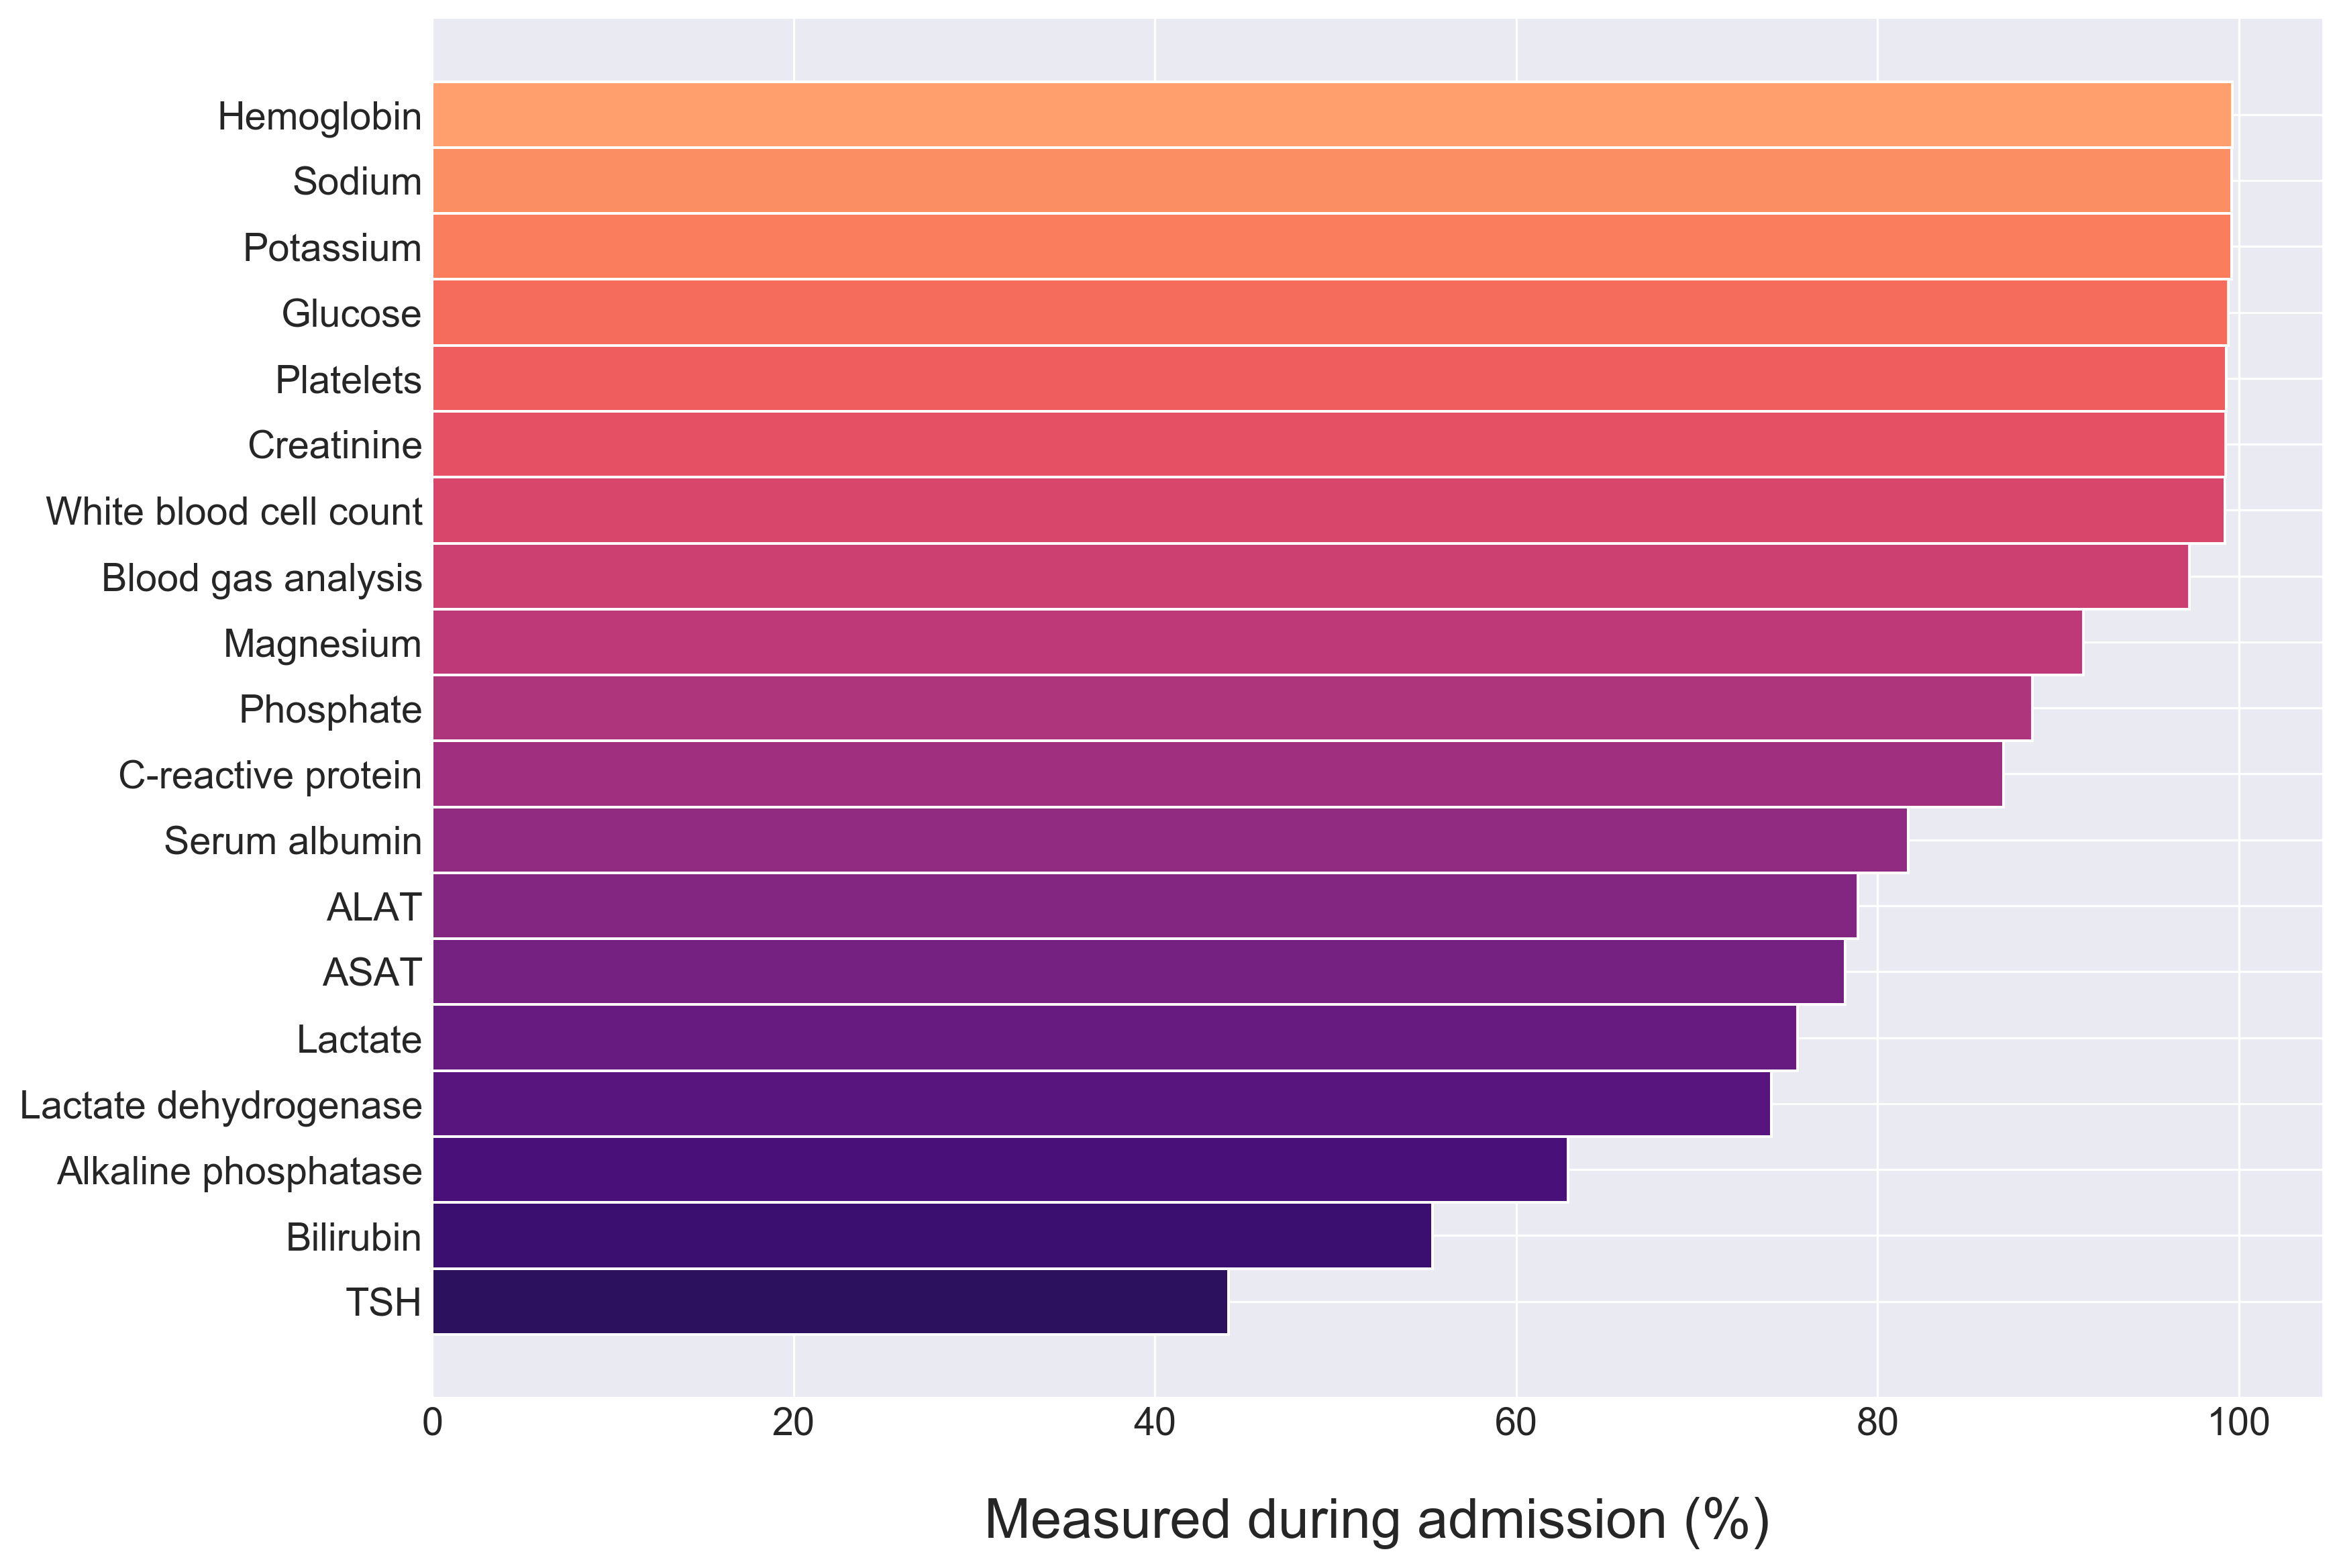

In [21]:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(labs_selection_mapped.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

fig, ax = plt.subplots(1, 1, figsize=(12,8), constrained_layout=True)
pos = 0
color_index = 0
for index, row in labs_selection_mapped.iterrows():
    ax.barh(row['mapped_item'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax.invert_yaxis()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Measured during admission (%)', fontsize='xx-large', labelpad=20)
ax.tick_params(axis='both', labelsize='large')

formats = ['png']
for format in formats:
    filename = 'fig2-labs.{}'.format(format)
    fig.savefig(filename, format=format, dpi=fig.dpi, bbox_inches='tight')
    
plt.close() #prevents the display of the plot using display rendering
Image(filename=filename)

## Get drugitems completeness

In [22]:
sql_drugitems_completeness = """
SELECT DISTINCT 
    --ordercategoryid, 
    --ordercategory, 
    itemid, 
    item, 
    COUNT(DISTINCT admissionid) AS n_admissions_documented
FROM drugitems
GROUP BY 
    --ordercategoryid, 
    --ordercategory, 
    itemid,
    item
ORDER BY COUNT(DISTINCT admissionid) DESC
"""
drugitems_completeness = pd.read_sql(sql_drugitems_completeness,con)
drugitems_completeness.head(5)

,itemid,item,n_admissions_documented
0,8937,Drukzak,20535
1,7291,"NaCl 0,45%/Glucose 2,5%",18354
2,6891,Paracetamol,18076
3,9424,"NaCL 0,9% spuit",17238
4,7148,Magnesiumsulfaat (MgSO4),16395


In [23]:
drugitems_completeness['completed_pt'] = 100*drugitems_completeness['n_admissions_documented']/num_admissions
drugitems_completeness.head(100)

,itemid,item,n_admissions_documented,completed_pt
0,8937,Drukzak,20535,88.873020
1,7291,"NaCl 0,45%/Glucose 2,5%",18354,79.433913
2,6891,Paracetamol,18076,78.230763
3,9424,"NaCL 0,9% spuit",17238,74.603999
4,7148,Magnesiumsulfaat (MgSO4),16395,70.955596
5,7480,Propofol (Diprivan),15367,66.506535
6,7293,"NaCl 0,9 %",13671,59.166450
7,7225,Morfine,11013,47.662945
8,7252,Gelofusine,10522,45.537956
9,7625,Nadroparine (Fraxiparine),9817,42.486800


In [24]:
drugs_selection = pd.DataFrame([
    [7480, 'Propofol'],
    [7225, 'Morphine'],
    [7229, 'Norepinephrine'],
    [9152, 'Cefazolin'],
    [7219, 'Fentanyl'],
    [7179, 'Dopamine'],
    [7624, 'Insulin'],
    [8429, 'Red blood cell transfusion'],
    [9138, 'SDD' ],
    [7196, 'Enoximone' ],
    [7244, 'Furosemide'],
    [9133, 'Ceftriaxone'],
    [12588, 'Nutrison Protein Plus'],
    [7194, 'Midazolam'],
    [7478, 'Nitroglycerin'],
    [7106, 'Hydrocortisone'],
    [7930, 'Heparin'],
    [6919, 'Cefotaxime'],
    [7097, 'Haloperidol'],
    [7064, 'Vancomycin']
], columns=['itemid', 'label'])

drugs_selection_new_labels = pd.merge( drugitems_completeness[drugitems_completeness.itemid.isin(
    drugs_selection['itemid'])], drugs_selection ).sort_values('completed_pt', ascending=False)
drugs_selection_new_labels

,itemid,item,n_admissions_documented,completed_pt,label
0,7480,Propofol (Diprivan),15367,66.506535,Propofol
1,7225,Morfine,11013,47.662945,Morphine
2,7229,Noradrenaline (Norepinefrine),8640,37.392885,Norepinephrine
3,9152,Cefazoline (Kefzol),8284,35.852160,Cefazolin
4,7219,Fentanyl,8186,35.428027,Fentanyl
5,7179,Dopamine (Inotropin),6963,30.135030,Dopamine
6,7624,Actrapid (Insuline),6928,29.983554,Insulin
7,7244,Furosemide (Lasix),6472,28.010041,Furosemide
8,8429,Gefiltreerde Ery's,6350,27.482039,Red blood cell transfusion
9,9138,SDD pasta (4 x dgs),5930,25.664330,SDD


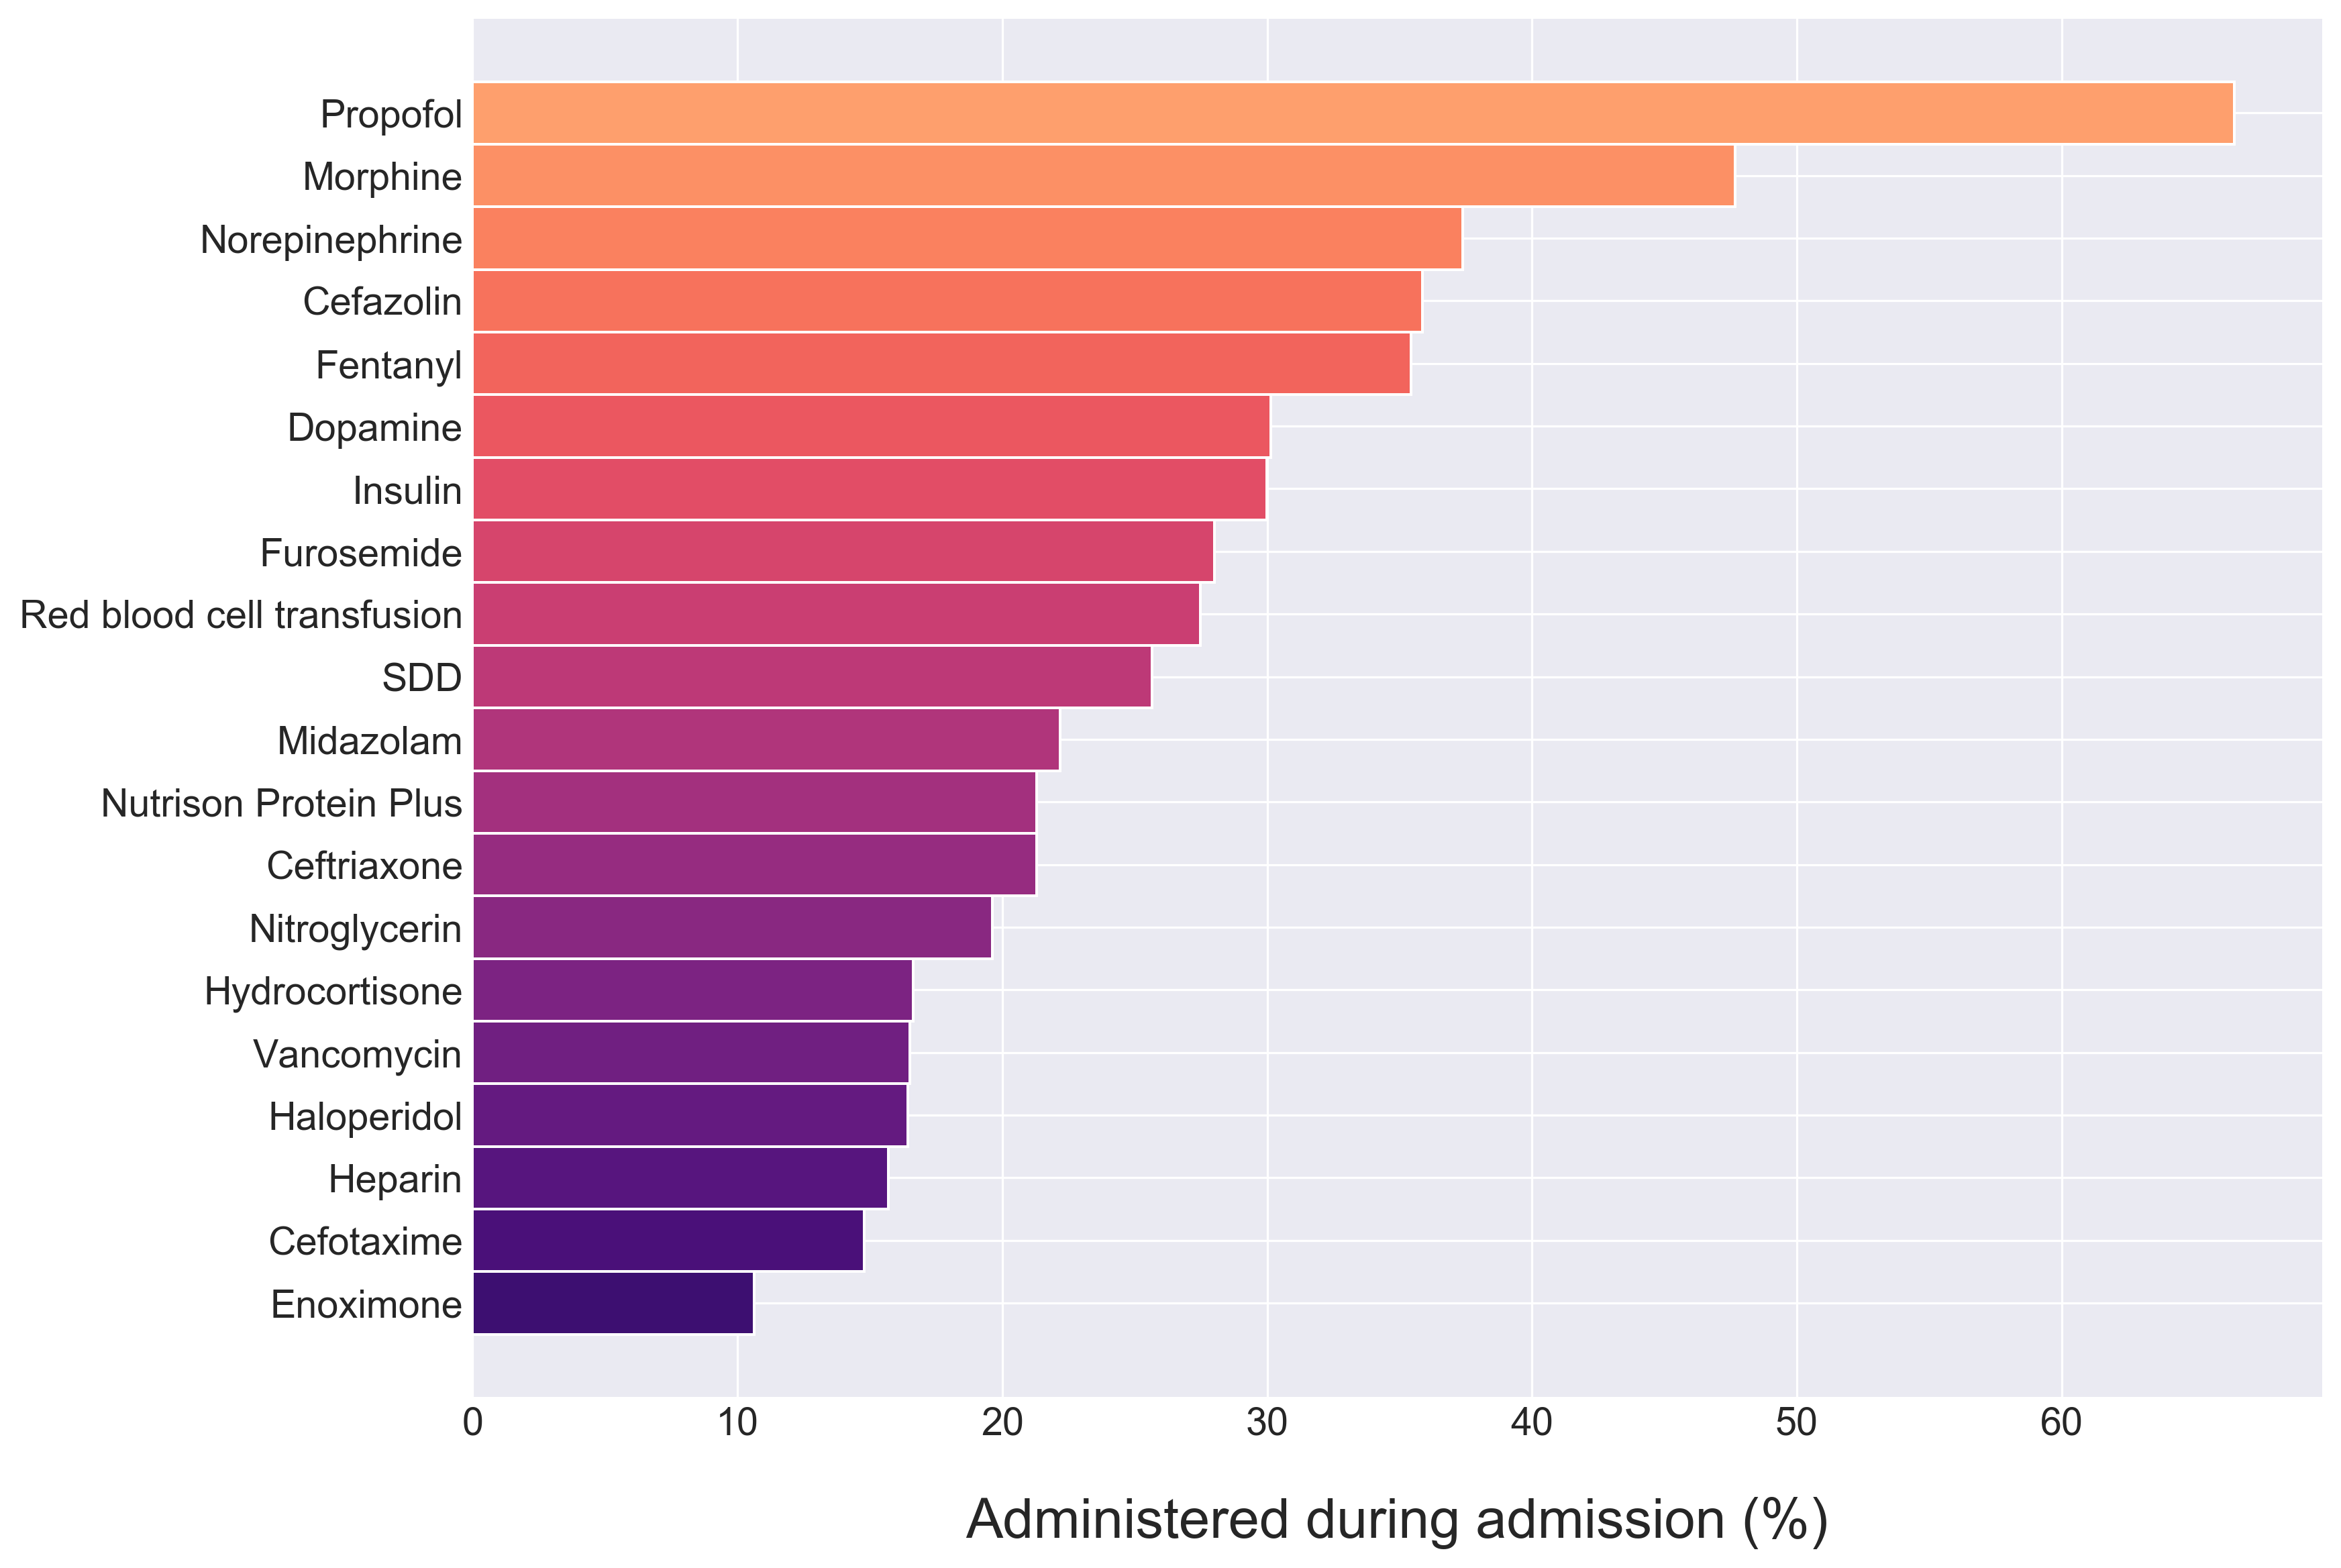

In [25]:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(drugs_selection_new_labels.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

fig, ax = plt.subplots(1, 1, figsize=(12,8), constrained_layout=True)
pos = 0
color_index = 0
for index, row in drugs_selection_new_labels.iterrows():
    ax.barh(row['label'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax.invert_yaxis()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Administered during admission (%)', fontsize='xx-large', labelpad=20)
ax.tick_params(axis='both', labelsize='large')

formats = ['png']
for format in formats:
    filename = 'fig2-drugs.{}'.format(format)
    fig.savefig(filename, format=format, dpi=fig.dpi, bbox_inches='tight')
    
plt.close() #prevents the display of the plot using display rendering
Image(filename=filename)

## Create a composite plot
Using 4 plots of completeness data for:
- device data
- manually entered
- labs
- drugs

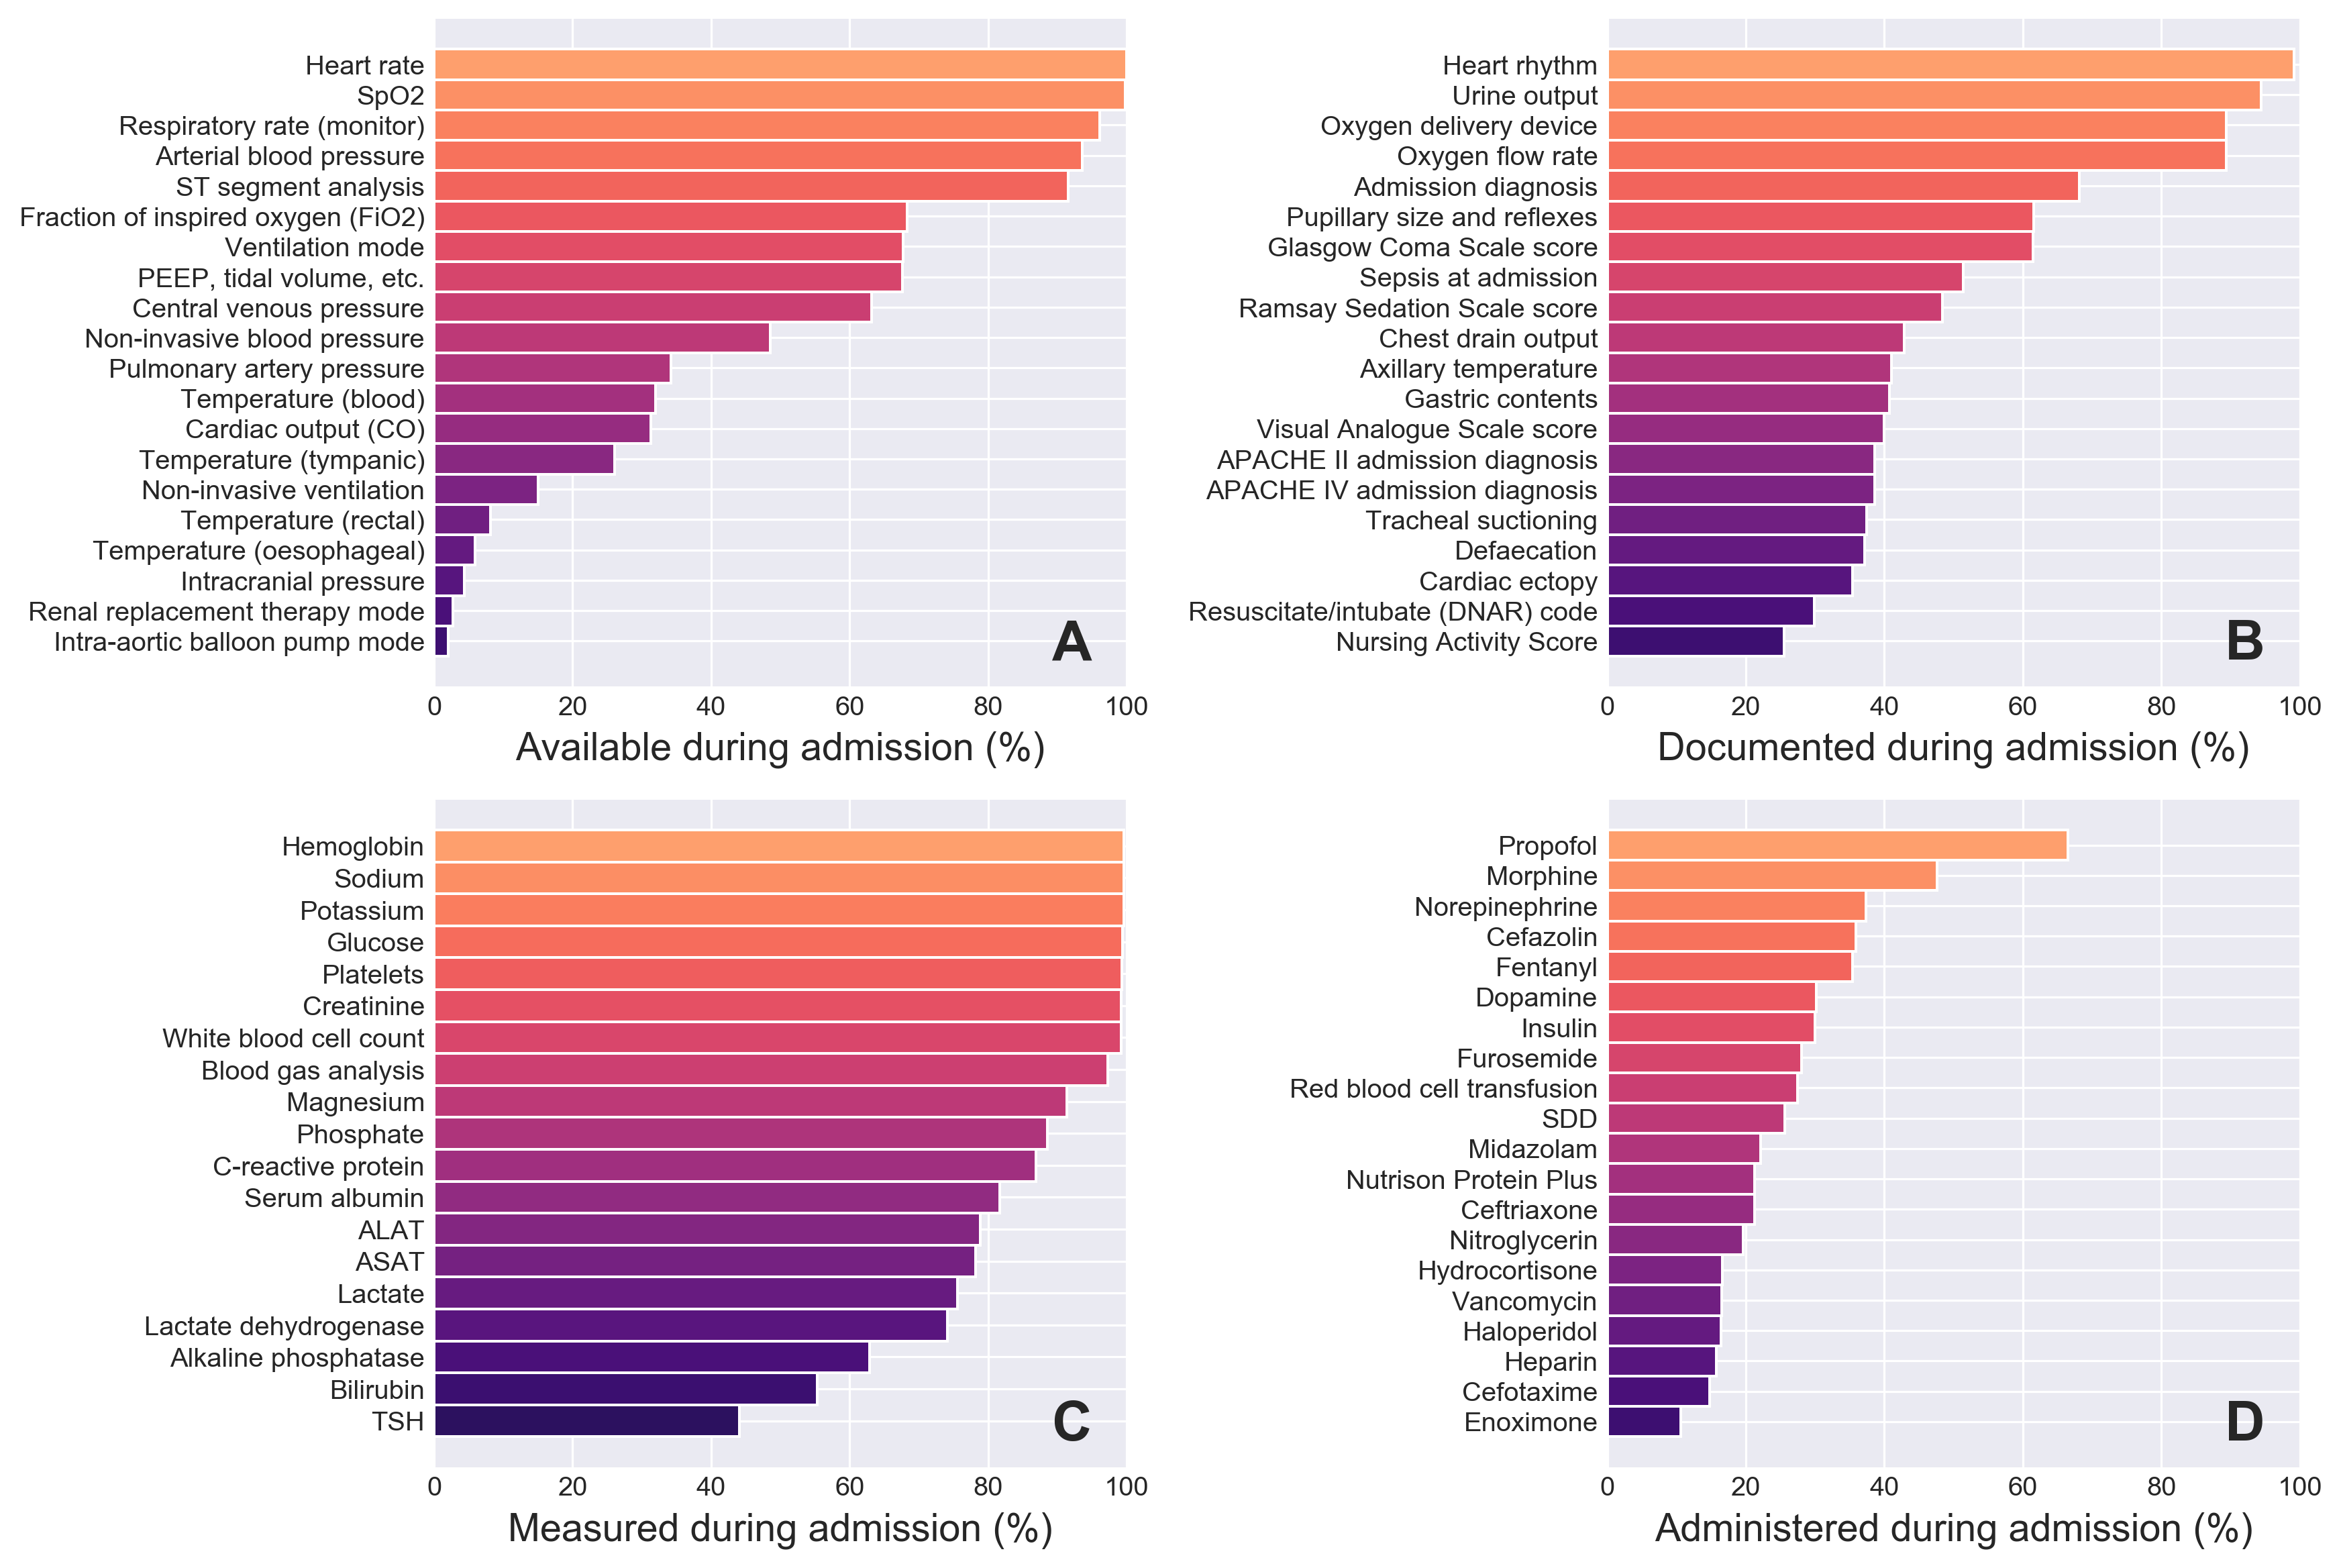

In [26]:
#defines all subplots here 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8), constrained_layout=True)

#sets all x-axes to the same range [0-100]
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax3.set_xlim(0,100)
ax4.set_xlim(0,100)

#Device data:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(device_data_selection_new_labels.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

pos = 0
color_index = 0
for index, row in device_data_selection_new_labels.iterrows():
    ax1.barh(row['label'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.set_xlabel('Available during admission (%)', fontsize='large')
ax1.tick_params(axis='both', labelsize='small')
ax1.text(0.95, 0.1, 'A', transform=ax1.transAxes, fontsize='xx-large', fontweight='bold', va='top', ha='right')

#Clinical observations:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(manual_items_selection_new_labels.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

pos = 0
color_index = 0
for index, row in manual_items_selection_new_labels.iterrows():
    ax2.barh(row['label'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_xlabel('Documented during admission (%)', fontsize='large')
ax2.tick_params(axis='both', labelsize='small')
ax2.text(0.95, 0.1, 'B', transform=ax2.transAxes, fontsize='xx-large', fontweight='bold', va='top', ha='right')

#labs:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(labs_selection_mapped.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

pos = 0
color_index = 0
for index, row in labs_selection_mapped.iterrows():
    ax3.barh(row['mapped_item'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax3.invert_yaxis()
ax3.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax3.set_xlabel('Measured during admission (%)', fontsize='large')
ax3.tick_params(axis='both', labelsize='small')
ax3.text(0.95, 0.1, 'C', transform=ax3.transAxes, fontsize='xx-large', fontweight='bold', va='top', ha='right')

#drugs:
cm = plt.cm.get_cmap('magma') 
color_step = int(255*0.7/len(drugs_selection_new_labels.index))
colors = cm(range(int(0.80*255),int(0.1*255),-color_step))

pos = 0
color_index = 0
for index, row in drugs_selection_new_labels.iterrows():
    ax4.barh(row['label'], row['completed_pt'], height=1,
            color=colors[color_index], ec='white', linewidth=1)
    color_index += 1

ax4.invert_yaxis()
ax4.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax4.set_xlabel('Administered during admission (%)', fontsize='large')
ax4.tick_params(axis='both', labelsize='small')
ax4.text(0.95, 0.1, 'D', transform=ax4.transAxes, fontsize='xx-large', fontweight='bold', va='top', ha='right')

formats = ['png']
for format in formats:
    filename = 'fig2.{}'.format(format)
    fig.savefig(filename, format=format, dpi=fig.dpi, bbox_inches='tight')
    
plt.close() #prevents the display of the plot using display rendering
Image(filename=filename)